# 538 Escape the Maze
Those pesky enemies of Riddler Nation are at it again! A couple of weeks ago, they trapped you in a maze without walls. Most of you escaped, but the enemies remain undeterred. They’ve been hard at work building a new maze without walls, shown below.

Before banishing you to the maze, they hand you a list of rules.

1. You can enter via any perimeter square. The goal is to reach the yellow star in the center with the lowest possible score, which is calculated by adding up all the numbers that appeared in any squares you crossed.
2. You can only move horizontally or vertically (not diagonally) to bordering squares.
3. If you enter a square with an arrow (↑), you have to exit that square in the direction the arrow indicates. Some squares have double arrows (↔), giving you a choice of two directions.
4. If you enter a square with a number, you must add it to your score, but you can exit in the direction of your choice.
5. If an arrow leads you to a square with a skull, you die. But you knew that already.

![Image of maze](https://fivethirtyeight.com/wp-content/uploads/2019/02/reigle.png?w=1150)

What is the lowest score you can achieve while solving the maze and saving Riddler Nation?

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Sample grid
We can represent the maze using a numpy array. Each element represents the action that can be taken:
* LR - left and right arrow
* UD - up and down arrow
* R - right arrow
* L - left arrow
* U - up arrow
* D - down arrow
* K - skull
* number - number to add to score

In [2]:
grid = np.array([['LR', 'R', 'UD', 'LR', 'L'],
                 ['K', 'L', 2, 'S', 'D'],
                 ['K', 'L', 'LR', 'U', 'L']
                ])

In [3]:
from matplotlib import colors

mapping = {'U': 0, 'R': 0, 'D': 0, 'L': 0, 'UD': 1, 'LR': 2, 'K': 3, 'S': 4, 'P':5}

In [4]:
def map_colorgrid(grid):
    """Map each box in the grid to a color."""
    N, M = grid.shape
    color_grid = np.zeros((N, M))

    for i in range(N):
        for j in range(M):
            if grid[i, j] in mapping:
                color_grid[i, j] = mapping[grid[i, j]]
            else:
                color_grid[i, j] = -1
    return color_grid


color_grid = map_colorgrid(grid)
color_grid

array([[ 2.,  0.,  1.,  2.,  0.],
       [ 3.,  0., -1.,  4.,  0.],
       [ 3.,  0.,  2.,  0.,  0.]])

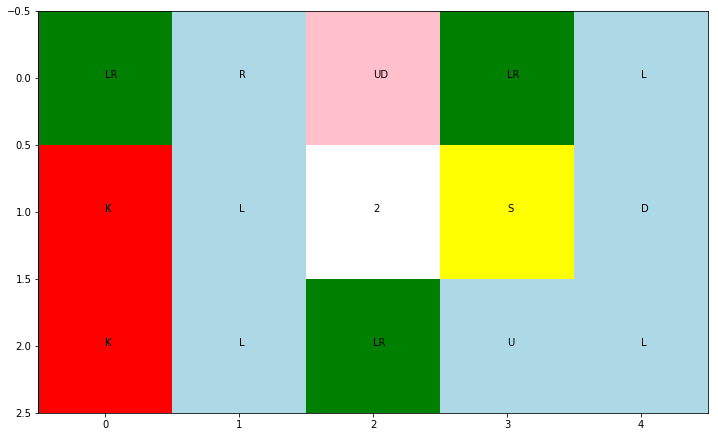

In [5]:
def plot_grid(grid, moveset=None):
    """Plot maze."""
    pathgrid = grid.copy()
    
    if moveset is None:
        cmap = colors.ListedColormap(['white', 'lightblue', 'pink', 'green', 'red', 'yellow'])
    else:
        for i, j in moveset:
            pathgrid[i, j] = 'P'
        cmap = colors.ListedColormap(['white', 'lightblue', 'pink', 'green', 'red', 'yellow', 'purple'])
    color_grid = map_colorgrid(pathgrid)
    
    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(color_grid, cmap=cmap)
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            ax.annotate(grid[i, j], (j, i))
    
plot_grid(grid)

In [6]:
def load_maze(path):
    """Load maze from csv."""
    output = []
    with open(path, 'r') as f:
        for line in f:
            # print(line.count(','))
            output.append(line.strip().split(','))
    return np.array(output)

## Load and visualize maze

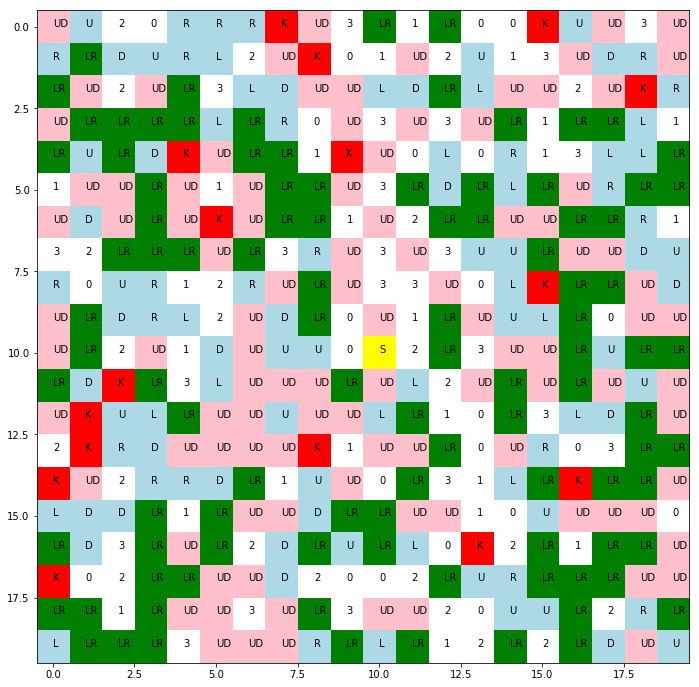

In [7]:
maze_grid = load_maze('maze.csv')
plot_grid(maze_grid)

In [8]:
# The number of movements are capped to the number of squares.
MOVE_MAX = 400

class Maze():
    def __init__(self, i, j, prior_move=None, movecount=0, score=0):
        """Maze position class. Represents a position in a maze."""
        self.i = i
        self.j = j
        self.prior_move = prior_move
        self.movecount = movecount
        self.score = score
        
    def _gen_move(self, currpos, grid):
        """Get move assuming a direction U/D/L/R."""
        i = self.i
        j = self.j
        prior_direction = 'N'
        if self.prior_move is not None:
            prior_direction = self.prior_move.position(grid)
            
        if currpos == 'L' and j > 1 and prior_direction != 'R':
            return Maze(i, j-1, self, movecount=self.movecount + 1,
                        score=self.score)
        elif currpos == 'R' and j < grid.shape[1] - 1 and prior_direction != 'L':
            return Maze(i, j+1, self, movecount=self.movecount + 1,
                        score=self.score)
        elif currpos == 'U' and i > 1 and prior_direction != 'D':
            return Maze(i-1, j, self, movecount=self.movecount + 1,
                        score=self.score)
        elif currpos == 'D' and i < grid.shape[0] - 1 and prior_direction != 'U':
            return Maze(i+1, j, self, movecount=self.movecount + 1,
                        score=self.score)
        return None
        
    def position(self, grid):
        """Get position detail."""
        return grid[self.i, self.j]
        
    def move_history(self):
        """Generate history of moves."""
        
        history = []
        move = self
    
        while move is not None:
            history.append((move.i, move.j))
            move = move.prior_move
        return history
    
    def _history_repeating(self):
        """Check if the current position has been traversed in the past."""
        move = self.prior_move
    
        while move is not None:
            if self.i == move.i and self.j == move.j:
                return True
            
            move = move.prior_move
            
        return False
        
    def moves(self, grid):
        """Get available moves from this position."""
        currpos = self.position(grid)
        if currpos in ['L', 'R', 'U', 'D']:
            return [self._gen_move(currpos, grid)]
        elif currpos == 'LR':
            return [self._gen_move(x, grid) for x in ['L', 'R']]
        elif currpos == 'UD':
            return [self._gen_move(x, grid) for x in ['U', 'D']]
        elif currpos in ['0', '1', '2', '3']:
            self.score += int(currpos)
            return [self._gen_move(x, grid) for x in ['U', 'D', 'L', 'R']]
        
        return []
            
    def status(self, grid, currscore=None):
        """Get status of current position (win/lose/in progress)."""
        currpos = grid[self.i, self.j]
        if currpos == 'S':
            return 0
        elif currpos == 'K':
            return 1
        # Cap the number of movements.
        elif self.movecount > MOVE_MAX:
            return 1
        # Only pursue paths that have a potential of beating the current path
        elif currscore is not None:
            if self.score >= currscore:
                return 1
        # Avoid moving to areas that have already been traversed.
        elif self._history_repeating():
            return 1
        
        return -1
    
    def __repr__(self):
        return "Maze(Loc: ({}, {}), Score: {}, Steps: {})".format(self.i, self.j, self.score, self.movecount)
        
Maze(0, 0, 0)

Maze(Loc: (0, 0), Score: 0, Steps: 0)

In [9]:
def run_game(grid):
    """Explore potential paths and record the best path."""
    queue = []
    
    # Add all perimeter positions to the queue.
    for i in range(grid.shape[0]):        
        queue.append(Maze(i, 0))
        queue.append(Maze(i, grid.shape[1]-1))
    for j in range(1, grid.shape[1] - 1):
        queue.append(Maze(0, j))
        queue.append(Maze(grid.shape[0]-1, j))
        
    currscore = None
    iteration = 0
    best_history = None
    while len(queue) > 0:
        try:
            iteration += 1
            if iteration % 100000 == 0:
                print("Iteration", iteration)
                print("Size of queue", len(queue))
                print("Last move", queue[-1])

            # Choose breadth first or depth first. 
            # Breadth first is appropriate for this problem.
            move = queue.pop(0)
            if move is None:
                continue
            status = move.status(grid, currscore)
            if status == 0:
                if currscore is None:
                    print("Won the game with a move of", move)
                    best_history = move.move_history()
                    print(best_history)
                    currscore = move.score
                elif move.score < currscore:
                    print("Won the game with a move of", move)

                    best_history = move.move_history()
                    print(best_history)
                    currscore = move.score
                if currscore == 0:
                    pass
            elif status == -1:
                queue.extend(move.moves(grid))
        except:
            break
    return best_history

Example solution for the sample grid. The purple highlights the path from the outer perimeter.

Won the game with a move of Maze(Loc: (1, 3), Score: 0, Steps: 1)
[(1, 3), (2, 3)]


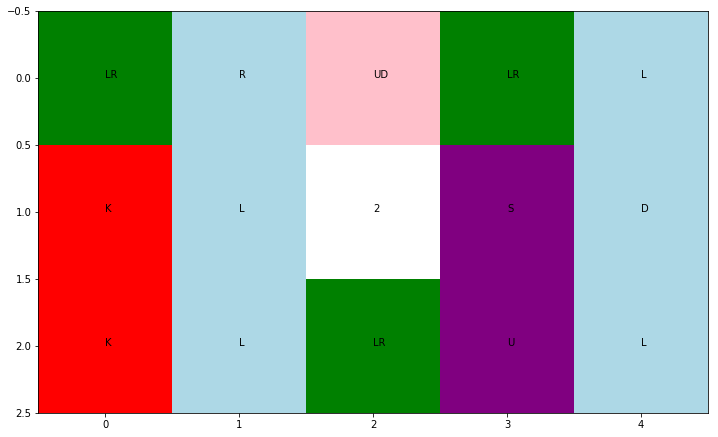

In [10]:
plot_grid(grid, run_game(grid))

## Solution
The purple highlights the path from the outer perimeter. You may stop execution early and still print the best solution that has been found. Because we use breadth first search, solutions with shorter paths are traversed first.

Won the game with a move of Maze(Loc: (10, 10), Score: 10, Steps: 11)
[(10, 10), (9, 10), (8, 10), (7, 10), (6, 10), (5, 10), (5, 11), (4, 11), (3, 11), (2, 11), (1, 11), (0, 11)]
Won the game with a move of Maze(Loc: (10, 10), Score: 9, Steps: 12)
[(10, 10), (11, 10), (11, 11), (11, 12), (12, 12), (12, 13), (12, 14), (12, 15), (12, 16), (13, 16), (13, 17), (13, 18), (13, 19)]
Won the game with a move of Maze(Loc: (10, 10), Score: 5, Steps: 13)
[(10, 10), (10, 11), (10, 12), (10, 13), (9, 13), (8, 13), (8, 14), (9, 14), (9, 15), (9, 16), (9, 17), (10, 17), (10, 18), (10, 19)]
Won the game with a move of Maze(Loc: (10, 10), Score: 3, Steps: 13)
[(10, 10), (10, 11), (9, 11), (9, 12), (8, 12), (8, 13), (8, 14), (9, 14), (9, 15), (9, 16), (9, 17), (10, 17), (10, 18), (10, 19)]
Won the game with a move of Maze(Loc: (10, 10), Score: 1, Steps: 13)
[(10, 10), (9, 10), (9, 11), (9, 12), (8, 12), (8, 13), (8, 14), (9, 14), (9, 15), (9, 16), (9, 17), (10, 17), (10, 18), (10, 19)]
Iteration 100000

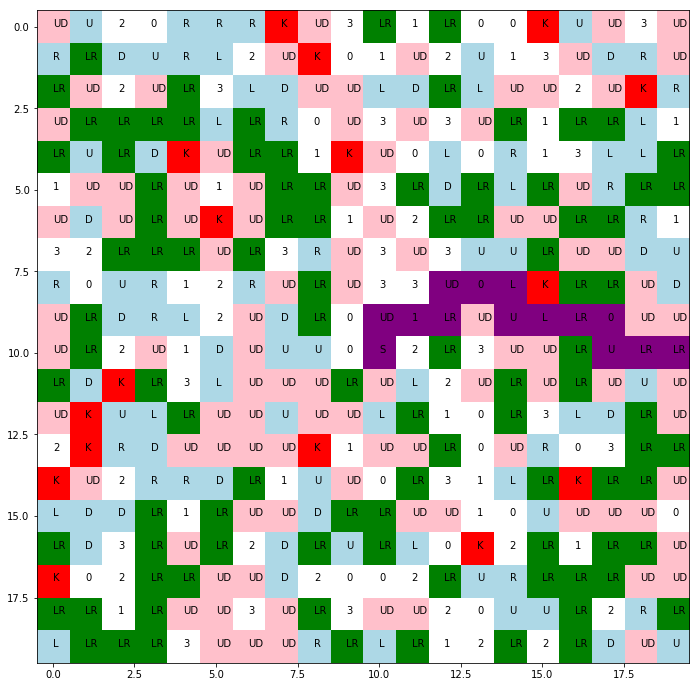

In [11]:
plot_grid(maze_grid, run_game(maze_grid))